In [10]:
!pip install pandas numpy seaborn matplotlib tqdm statsmodels

<h2 style="color:darkred">IMPORTING LIBRARIES</h2>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error ,mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
from IPython.display import Image 
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load the CSV file into a DataFrame
file_path = 'weather_revised.csv'
df_weather = pd.read_csv(file_path, encoding='ascii')

# Display the head of the DataFrame
df_weather.head()

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-42,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-42,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-42,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,4-Jan-42,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,5-Jan-42,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7


<h2 style="color:darkred">DATA PRE-PROCESSING </h2>

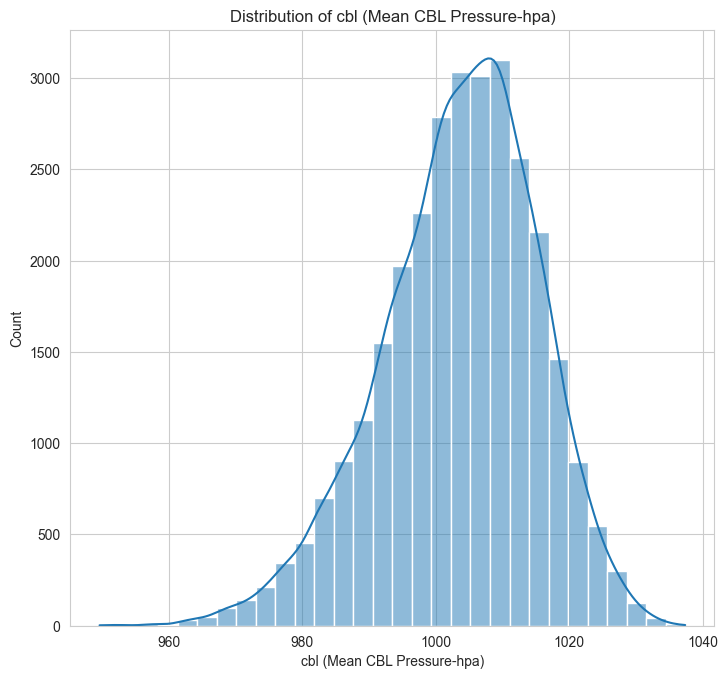

In [13]:
def plot_distributions(dataframe, columns):
    # Set the aesthetic style of the plots
    sns.set_style('whitegrid')
    
    # Define the number of rows and columns for subplots
    num_rows = (len(columns) + 1)
    num_cols = 2
    
    plt.figure(figsize=(14, 7 + 3 * num_rows))
    
    # Plot each distribution
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(dataframe[column], bins=30, kde=True)
        plt.title(f'Distribution of {column}')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
selected_columns = ['cbl (Mean CBL Pressure-hpa)']

plot_distributions(df_weather, selected_columns)

In [14]:
# Summary statistics for maxtp
print(df_weather['cbl (Mean CBL Pressure-hpa)'].describe())

count    29889.000000
mean      1003.520208
std         11.723154
min        949.600000
25%        996.200000
50%       1004.600000
75%       1011.700000
max       1037.400000
Name: cbl (Mean CBL Pressure-hpa), dtype: float64


In [15]:
#Check datatypes of data
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         29889 non-null  object 
 1   maxtp(Maximum Air Temperature - degrees C)   29889 non-null  float64
 2   mintp(Minimum Air Temperature - degrees C)   29889 non-null  float64
 3   gmin(Grass Minimum Temperature - degrees C)  29889 non-null  object 
 4   rain(Precipitation Amount - mm)              29889 non-null  float64
 5   cbl (Mean CBL Pressure-hpa)                  29889 non-null  float64
 6   wdsp(Mean Wind Speed - knot)                 29889 non-null  float64
 7   pe(Potential Evapotranspiration - mm)        29889 non-null  float64
 8   evap(Evaporation -mm)                        29889 non-null  object 
dtypes: float64(6), object(3)
memory usage: 2.1+ MB
None


<h2 style="color:darkred">Checking Missing, Unique, Duplicate, NaN values count</h2>

In [16]:
# check for missing values, unique and duplicate values
missing_values = df_weather.isnull().sum()
unique_values = df_weather.nunique()
duplicated_rows = df_weather.duplicated().sum()
Nan_values = df_weather.isna().sum()

result = pd.DataFrame({
    "Unique values": unique_values,
    "Missing values": missing_values,
    "Duplicated values": duplicated_rows,
    
    "NaN values": Nan_values
})
result

,Unique values,Missing values,Duplicated values,NaN values
date,29889,0,0,0
maxtp(Maximum Air Temperature - degrees C),294,0,0,0
mintp(Minimum Air Temperature - degrees C),269,0,0,0
gmin(Grass Minimum Temperature - degrees C),300,0,0,0
rain(Precipitation Amount - mm),361,0,0,0
cbl (Mean CBL Pressure-hpa),731,0,0,0
wdsp(Mean Wind Speed - knot),291,0,0,0
pe(Potential Evapotranspiration - mm),55,0,0,0
evap(Evaporation -mm),76,0,0,0


In [17]:
# Convert date column to datetime
# The dates are in the format 'd-Mon-yy', and we need to account for the century
def parse_date(x):
    day, month, year = x.split('-')
    year = '19' + year if int(year) <= 99 and int(year) >= 42 else '20' + year
    return '-'.join([day, month, year])

In [18]:
df_weather_processed = df_weather.copy()

# Apply parse_date function
df_weather_processed['date'] = df_weather['date'].apply(parse_date)

In [19]:
df_weather_processed.head(3)

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-1942,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-1942,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-1942,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6


In [20]:
# Convert to datetime
df_weather_processed['date'] = pd.to_datetime(df_weather_processed['date'], format='%d-%b-%Y', errors='coerce')

In [21]:
df_weather['date'].head()

0    1-Jan-42
1    2-Jan-42
2    3-Jan-42
3    4-Jan-42
4    5-Jan-42
Name: date, dtype: object

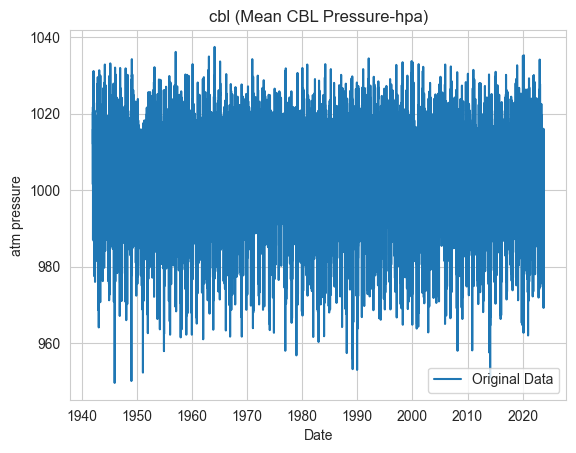

In [22]:
plt.plot(df_weather_processed['date'], df_weather_processed['cbl (Mean CBL Pressure-hpa)'], label='Original Data')
plt.title('cbl (Mean CBL Pressure-hpa)')
plt.xlabel('Date')
plt.ylabel('atm pressure')
plt.legend()
plt.show()

In [23]:
print(df_weather_processed.columns)


Index(['date', 'maxtp(Maximum Air Temperature - degrees C)',
       'mintp(Minimum Air Temperature - degrees C)',
       'gmin(Grass Minimum Temperature - degrees C)',
       'rain(Precipitation Amount - mm)', 'cbl (Mean CBL Pressure-hpa)',
       'wdsp(Mean Wind Speed - knot)', 'pe(Potential Evapotranspiration - mm)',
       'evap(Evaporation -mm)'],
      dtype='object')


In [24]:
df_weather_processed.head()

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1942-01-01,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,1942-01-02,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,1942-01-03,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,1942-01-04,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,1942-01-05,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7


In [25]:
df_weather_processed.set_index('date', inplace=True)

<h2 style="color:darkred">Detecting Outliers</h2>

In [26]:
Conti_Features = ['cbl (Mean CBL Pressure-hpa)']

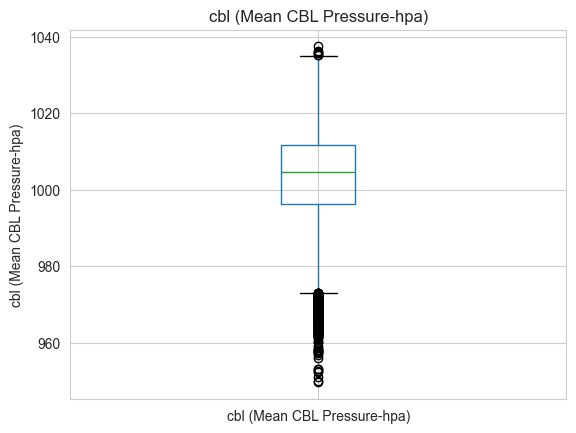

In [27]:
for feature in Conti_Features:
        df_weather_processed.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()
        

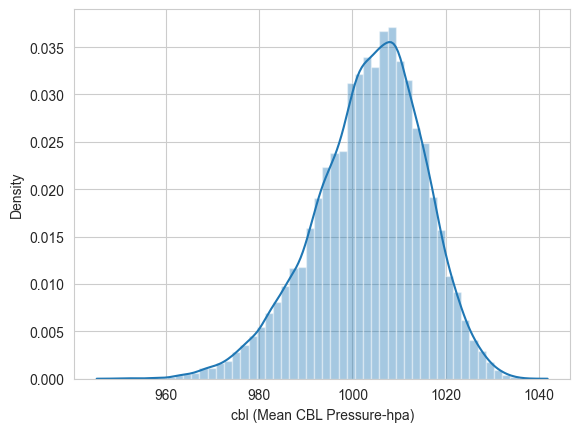

In [28]:
for var in Conti_Features:
    sns.distplot(df_weather_processed[var])
    plt.show()

In [29]:
for feature in Conti_Features:
    Q1 = df_weather_processed[feature].quantile(0.25)
    Q3 = df_weather_processed[feature].quantile(0.75)
    IQR = Q3 - Q1
    print('IQR of {} is '.format(feature),IQR )

IQR of cbl (Mean CBL Pressure-hpa) is  15.5


In [30]:
for feature in Conti_Features:
    print(feature ," - ", df_weather_processed[feature].skew())
    

cbl (Mean CBL Pressure-hpa)  -  -0.4637217911105772


In [31]:
atm_pressure = df_weather_processed.copy()

In [32]:
# Quantile-based Flooring and Capping 
for feature in Conti_Features:
        Q1 = atm_pressure[feature].quantile(0.25)
        Q3 = atm_pressure[feature].quantile(0.75)

        IQR = Q3-Q1

        outliers_atm_data = ((atm_pressure[feature] < (Q1-1.5*IQR)) | (atm_pressure[feature] > (Q3+1.5*IQR))) #picked outliers
        median_N_col = atm_pressure[feature].median()
        #print(median_N_col)
        print(f'number of outliers: {atm_pressure[outliers_atm_data].shape[0]}')
        atm_pressure.loc[outliers_atm_data, feature] = median_N_col

for feature in Conti_Features:
    print(feature ," - ", atm_pressure[feature].skew())

number of outliers: 336
cbl (Mean CBL Pressure-hpa)  -  -0.2803704343767963


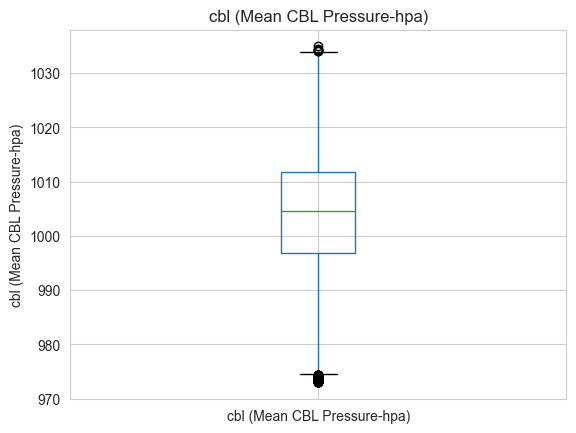

In [33]:
for feature in Conti_Features:
        atm_pressure.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

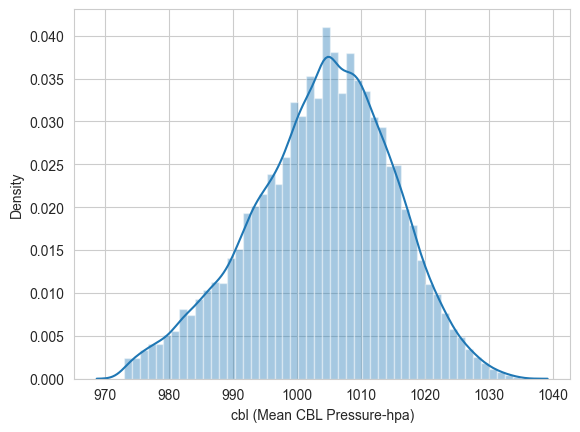

In [34]:
for var in Conti_Features:
    sns.distplot(atm_pressure[var])
    plt.show()

In [35]:
# Specify the time range for training (2019 to 2022) and testing (from 2023 onwards)
train_start_date = '2019-01-01'
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'

# Split the data into training and testing sets with daily frequency
train_df = atm_pressure[train_start_date:train_end_date]['cbl (Mean CBL Pressure-hpa)'].resample('M').fillna(method='pad')
test_df = atm_pressure[test_start_date:]['cbl (Mean CBL Pressure-hpa)'].resample('M').fillna(method='pad')


In [36]:
train_df.head()

date
2019-01-31     978.9
2019-02-28    1005.5
2019-03-31    1015.2
2019-04-30    1010.5
2019-05-31    1007.5
Freq: M, Name: cbl (Mean CBL Pressure-hpa), dtype: float64

In [37]:
test_df.head()

date
2023-01-31    1012.4
2023-02-28    1027.7
2023-03-31     982.9
2023-04-30    1006.6
2023-05-31    1019.2
Freq: M, Name: cbl (Mean CBL Pressure-hpa), dtype: float64

In [38]:
test_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 10 entries, 2023-01-31 to 2023-10-31
Freq: M
Series name: cbl (Mean CBL Pressure-hpa)
Non-Null Count  Dtype  
--------------  -----  
10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


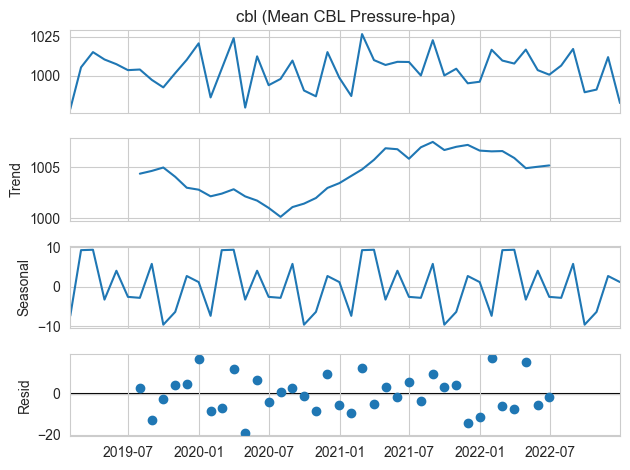

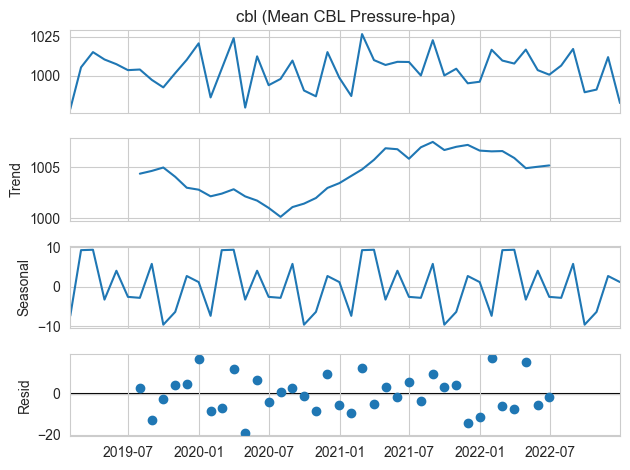

In [39]:
result = seasonal_decompose(train_df)
result.plot()

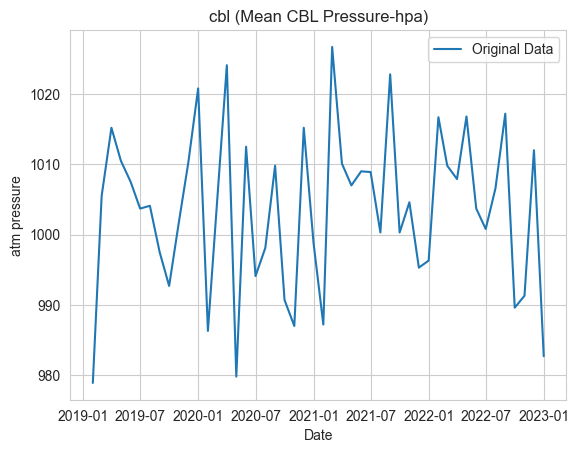

In [40]:
plt.plot( train_df, label='Original Data')
plt.title('cbl (Mean CBL Pressure-hpa)')
plt.xlabel('Date')
plt.ylabel('atm pressure')
plt.legend()
plt.show()

<h2 style="color:darkred">Checking whether Data is Stationary or Non-Stationary </h2>

In [41]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming your time series data is in the 'cbl (Mean CBL Pressure-hpa)' column
time_series_data = df_weather_processed['cbl (Mean CBL Pressure-hpa)']

# Perform Augmented Dickey-Fuller test
result = adfuller(time_series_data)
df_stationarityTest = adfuller(df_weather_processed['cbl (Mean CBL Pressure-hpa)'], autolag='AIC')

adf_statistic = df_stationarityTest[0]
print('ADF Statistic:', adf_statistic)
# Extract and print the p-value
p_value = result[1]
print("ADF Test p-value:", p_value)

# Check if the time series is stationary based on the p-value
if p_value <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -26.93013840772338
ADF Test p-value: 0.0
The time series is likely stationary.


In [42]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(30).mean()
    rolling_std = ts.rolling(30).std()
    plt.figure(figsize=(6,4))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

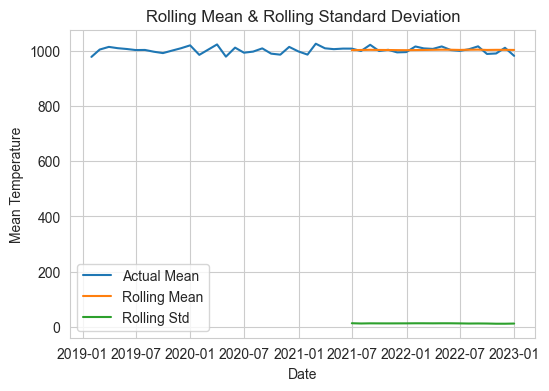

In [43]:
# check stationary: mean, variance(std)
plot_rolling_mean_std(train_df)

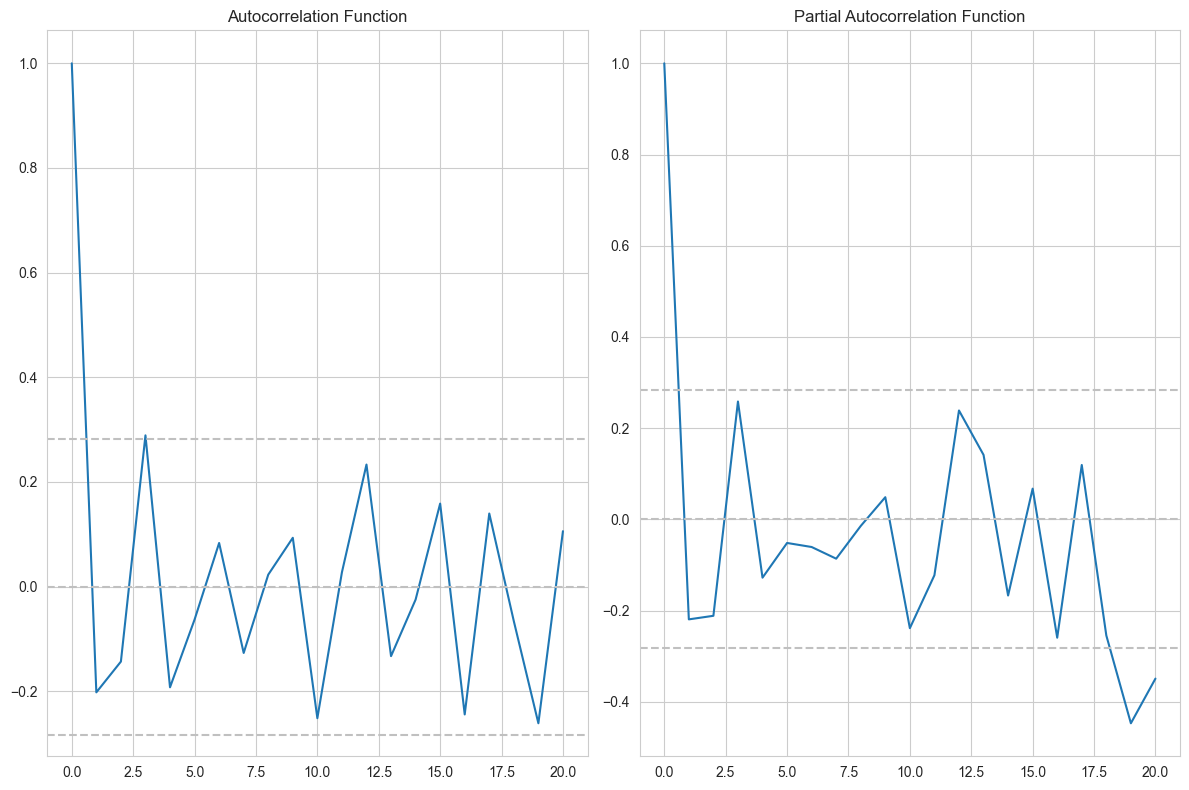

In [44]:
#Plot ACF and PACF
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

<h2 style="color:darkred">Ploting ACF and PACF </h2>

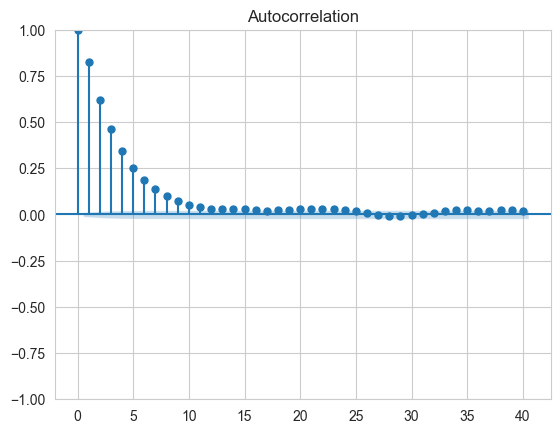

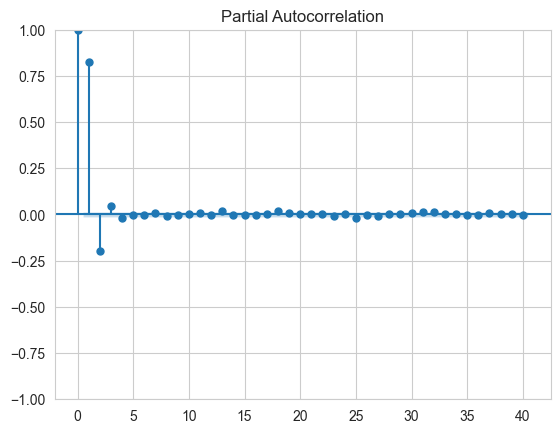

In [45]:
# Plot ACF and PACF to determine orders
plot_acf(atm_pressure['cbl (Mean CBL Pressure-hpa)'], lags=40)
plt.show()

plot_pacf(atm_pressure['cbl (Mean CBL Pressure-hpa)'], lags=40)
plt.show()

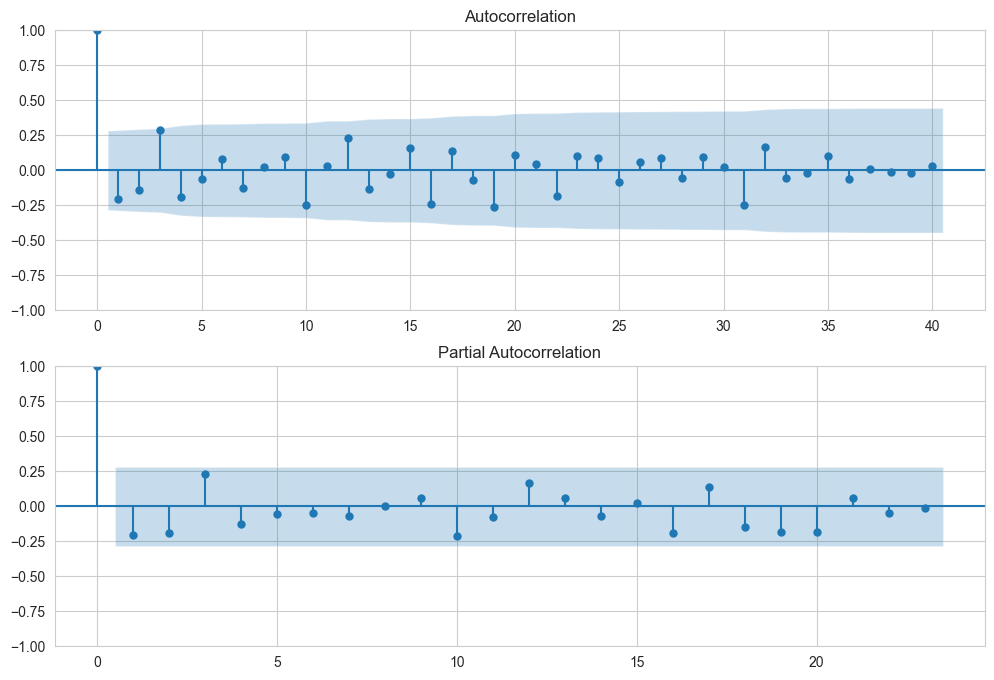

In [46]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df,lags=23,ax=ax2)

<h2 style="color:darkred">Forecasting Using AR MODEL </h2>

In [47]:
lags = 21
model = AutoReg(train_df, lags=lags)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                                 AutoReg Model Results                                 
Dep. Variable:     cbl (Mean CBL Pressure-hpa)   No. Observations:                   48
Model:                             AutoReg(21)   Log Likelihood                 -86.551
Method:                        Conditional MLE   S.D. of innovations              5.969
Date:                         Mon, 08 Jan 2024   AIC                            219.101
Time:                                 14:21:36   BIC                            248.905
Sample:                             10-31-2020   HQIC                           227.963
                                  - 12-31-2022                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            4090.2344   1132.365      3.612      0.000    1870.841    6309.

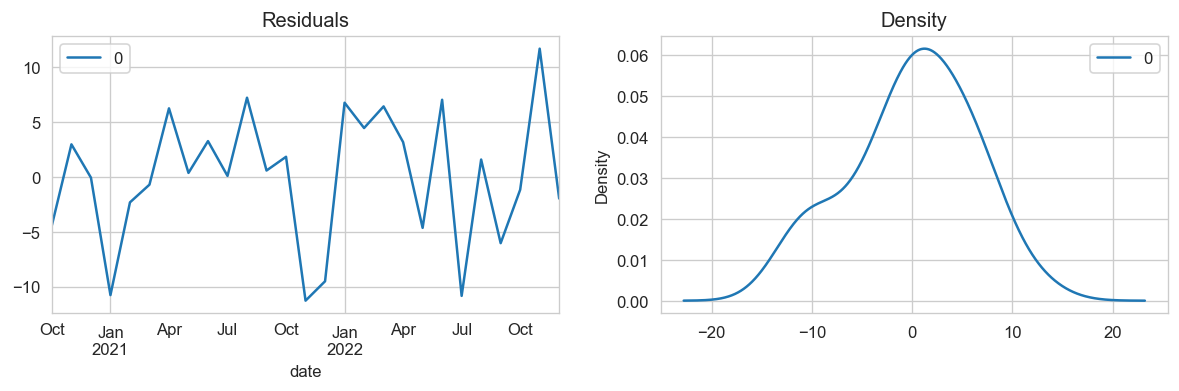

In [48]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Mean Absolute Error (MAE): 13.101954188749016
Test Mean Squared Error:  211.19804051863315
Root Mean Squared Error (RMSE): 14.53265428332461


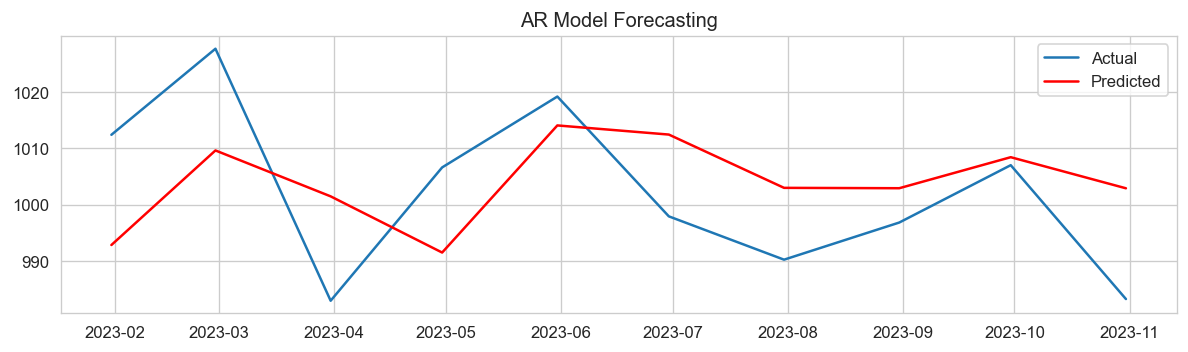

In [49]:
# Make predictions on the test set
predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, dynamic=False)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, predictions)


print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, predictions)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the original vs. predicted values
plt.plot(test_df.index, test_df.values, label='Actual')
plt.plot(test_df.index, predictions, color='red', label='Predicted')
plt.title('AR Model Forecasting')
plt.legend()
plt.show()

<h2 style="color:darkred">Forecasting Using ARIMA MODEL </h2>

In [50]:
 model = ARIMA(train_df.values, order=(2, 0,8))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(2, 0, 8)   Log Likelihood                -179.158
Date:                Mon, 08 Jan 2024   AIC                            382.317
Time:                        14:21:39   BIC                            404.771
Sample:                             0   HQIC                           390.802
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1003.9721      0.978   1026.600      0.000    1002.055    1005.889
ar.L1         -0.1418      0.841     -0.169      0.866      -1.789       1.506
ar.L2          0.5180      0.728      0.711      0.4

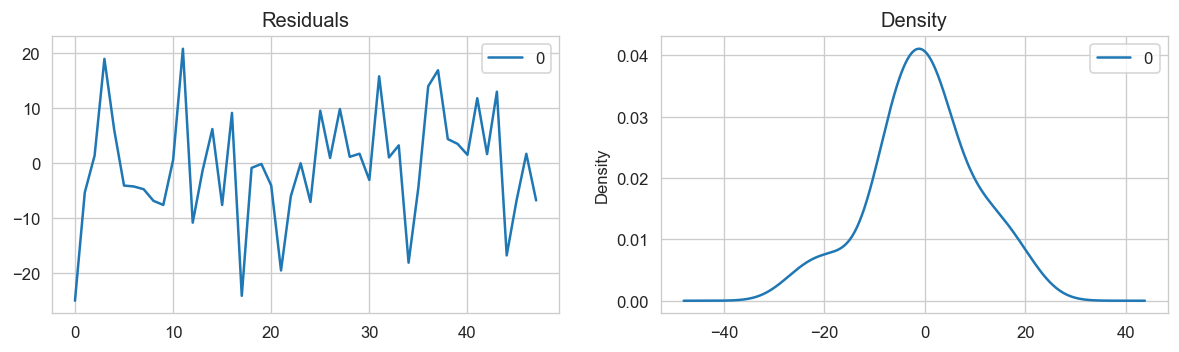

In [51]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

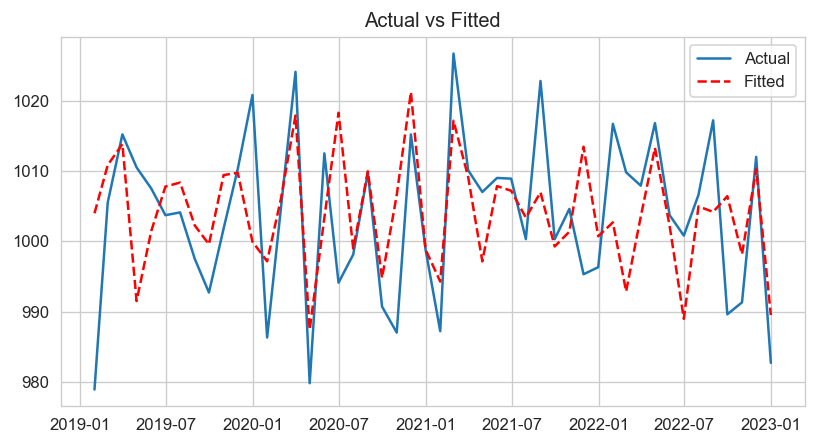

In [52]:
# Actual vs Fitted
plt.figure(figsize=(8, 4))
plt.plot(train_df.index, train_df.values, label='Actual')
plt.plot(train_df.index, model_fit.fittedvalues, color='red', label='Fitted', linestyle='--')
plt.legend()
plt.title('Actual vs Fitted')
plt.show()

In [53]:
# Forecast values for test_df
forecast_result = model_fit.get_forecast(10, alpha=0.05)

forecast_result

In [54]:
# Extracting forecast, standard errors, and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

In [55]:
# Make as pandas series

fc_series_AR = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

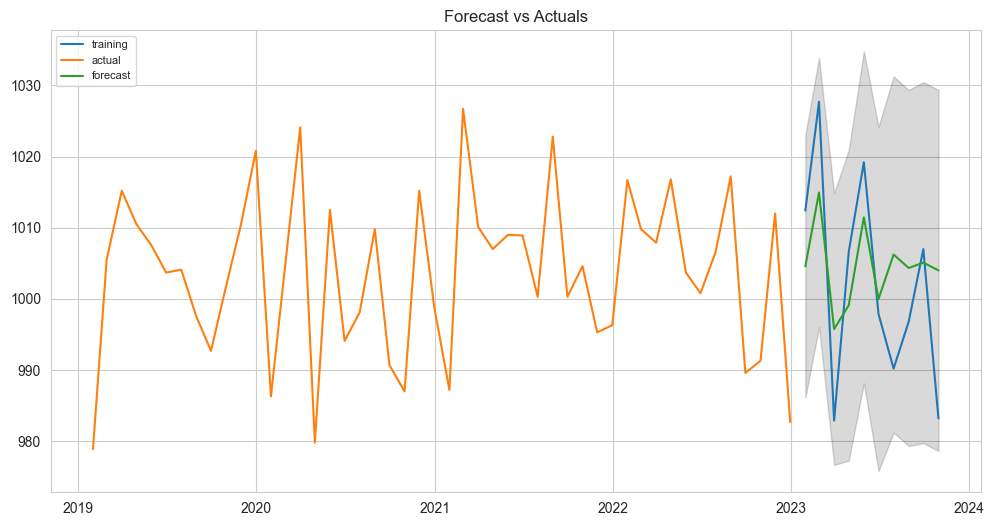

In [56]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_df, label='training')
plt.plot(train_df, label='actual')
plt.plot(fc_series_AR, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

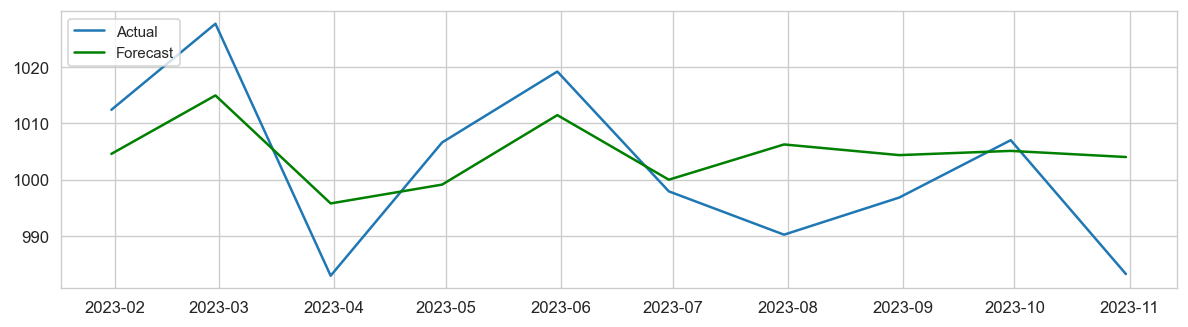

In [57]:
# plot Testing and Forecasted data
plt.plot(test_df, label='Actual')
plt.plot(fc_series_AR, label='Forecast', color='green')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [58]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_AR)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_AR)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 9.705136269981846
Test Mean Squared Error:  126.03670762578199
Root Mean Squared Error (RMSE): 11.226607128860525


<h2 style="color:darkred">Forecasting Using SARIMA </h2>

In [59]:
# Specify the order and seasonal_order based on ACF and PACF analysis
order = (3, 0, 8)
seasonal_order = (3, 0, 8, 10)

# Create and fit the SARIMA model
sarima_model = SARIMAX(train_df, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Display the model summary
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:        cbl (Mean CBL Pressure-hpa)   No. Observations:                   48
Model:             SARIMAX(3, 0, 8)x(3, 0, 8, 10)   Log Likelihood                -185.162
Date:                            Mon, 08 Jan 2024   AIC                            416.324
Time:                                    14:22:07   BIC                            459.361
Sample:                                01-31-2019   HQIC                           432.588
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0368      0.662     -0.056      0.956      -1.335       1.262
ar.L2          0.0724      1.956   

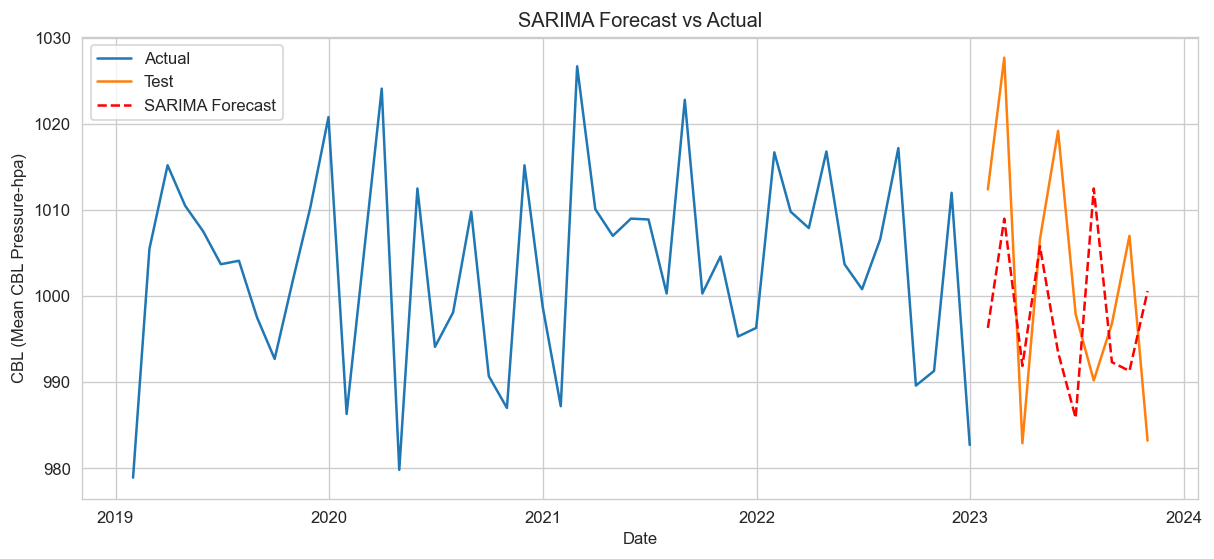

In [60]:
# Get the forecast
forecast_steps = 10
sarima_forecast = sarima_model_fit.get_forecast(steps=forecast_steps)

# Plot the actual values and the forecasted values
plt.figure(figsize=(12, 5))
plt.plot(train_df, label='Actual')
plt.plot(test_df,label='Test')
plt.plot(sarima_forecast.predicted_mean, color='red', label='SARIMA Forecast',linestyle='--')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend()
plt.show()


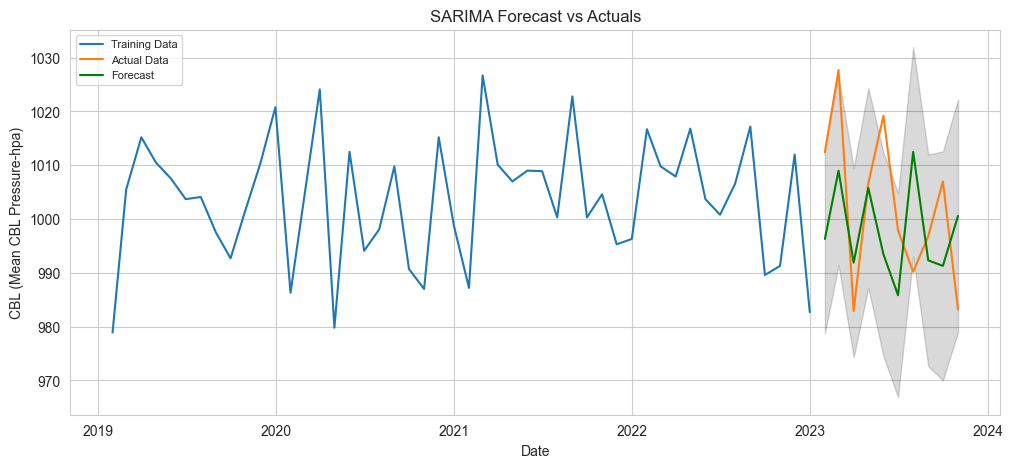

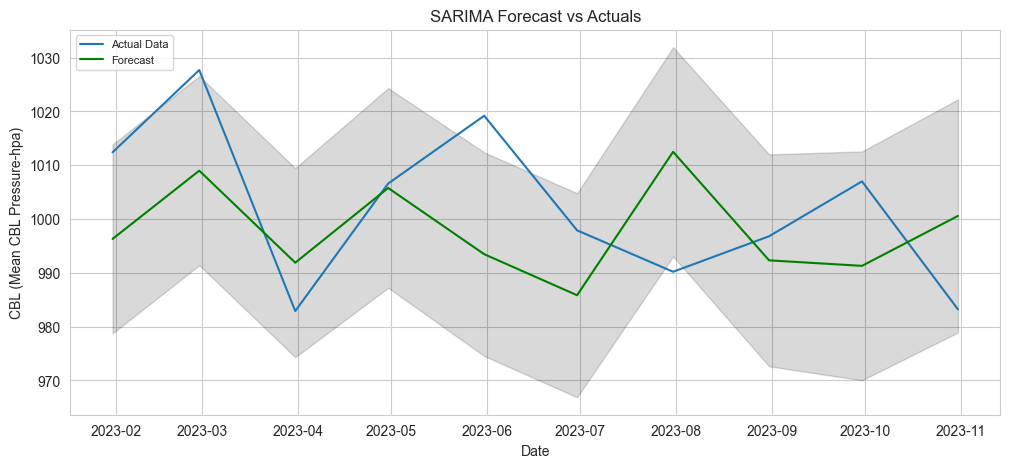

In [61]:
# Get the forecast
forecast_result = sarima_model_fit.get_forecast(steps=10, alpha=0.05)

# Extract forecasted values and confidence intervals
fc = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Make pandas series
fc_series_SR = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test_df.index)

# Plotting forecast vs actuals with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Actual Data')
plt.plot(fc_series_SR, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plotting only the forecasted values with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_df, label='Actual Data')

plt.plot(fc_series_SR, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [62]:

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_SR)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_SR)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 14.227013868868255
Test Mean Squared Error:  256.4038453201796
Root Mean Squared Error (RMSE): 16.012615193033884


<h2 style="color:darkred">Forecasting Using Exponential Smoothing </h2>

                           ExponentialSmoothing Model Results                          
Dep. Variable:     cbl (Mean CBL Pressure-hpa)   No. Observations:                   48
Model:                    ExponentialSmoothing   SSE                           5252.818
Optimized:                                True   AIC                            253.375
Trend:                                Additive   BIC                            279.572
Seasonal:                             Additive   AICC                           270.924
Seasonal Periods:                           10   Date:                 Mon, 08 Jan 2024
Box-Cox:                                 False   Time:                         14:22:10
Box-Cox Coeff.:                           None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08     

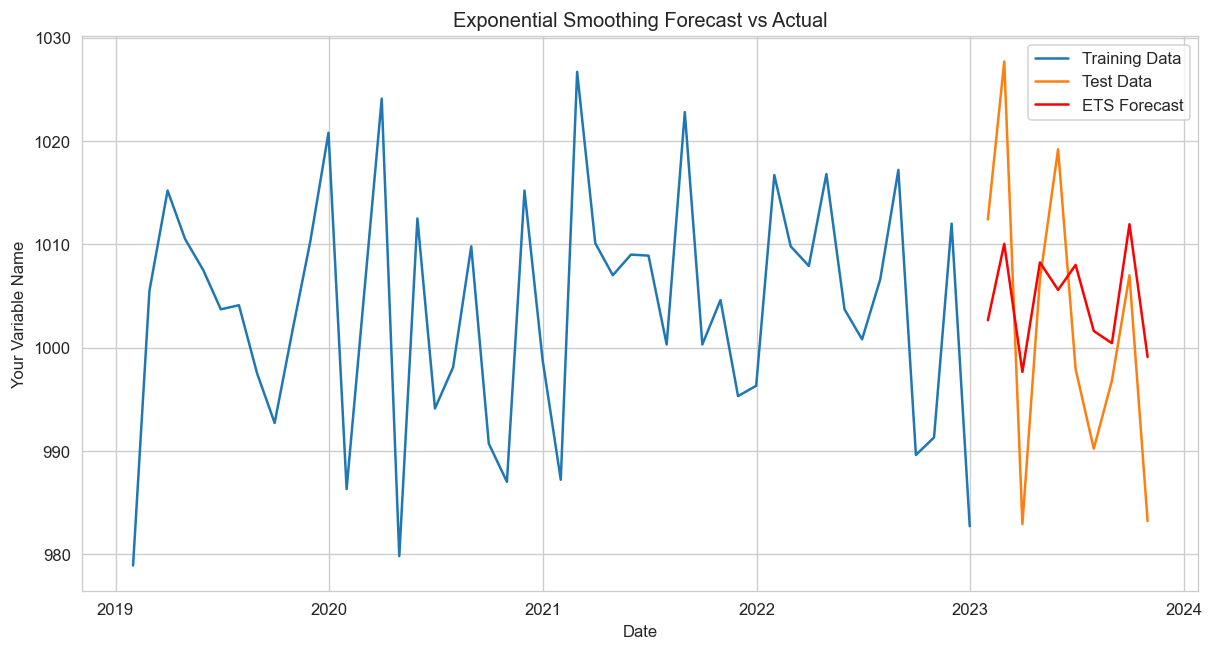

In [63]:
ets_model = ExponentialSmoothing(train_df, trend='add', seasonal='add', seasonal_periods=10)
ets_model_fit = ets_model.fit()

# Specify the number of steps to forecast (length of test_df)
forecast_steps = 10

# Get the forecast
ets_forecast = ets_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
print(ets_model_fit.summary())

# Plot the actual values and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df, label='Training Data')
plt.plot(test_df.index, test_df, label='Test Data')
plt.plot(test_df.index, ets_forecast, color='red', label='ETS Forecast')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Your Variable Name')
plt.legend()
plt.show()

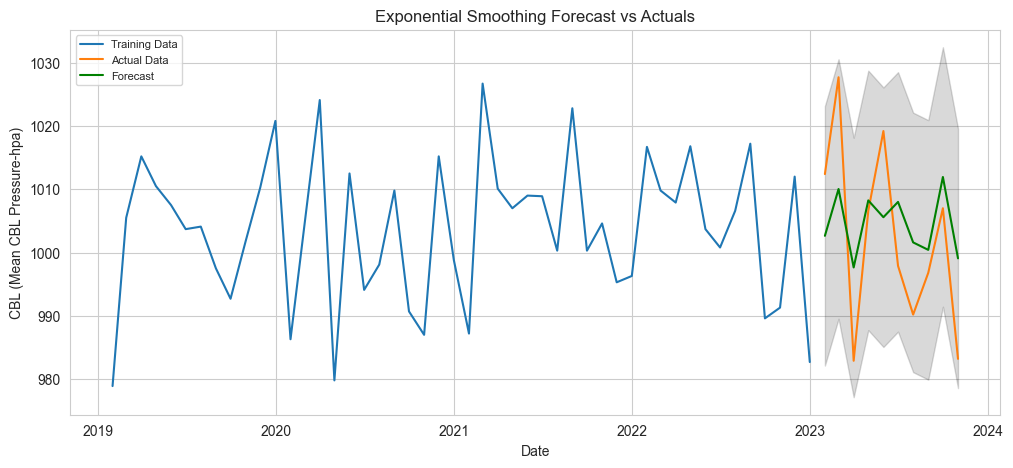

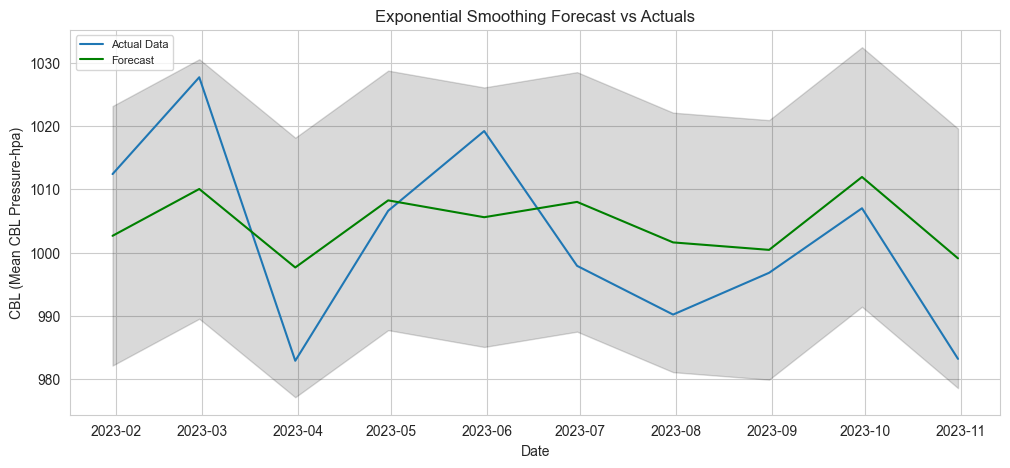

In [64]:
# Specify the number of steps to forecast
forecast_steps = 10

# Get the forecast
ets_forecast = ets_model_fit.forecast(steps=forecast_steps)

# Calculate prediction intervals manually
confidence_interval = 0.95
forecast_std = np.std(ets_model_fit.resid)
z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
lower_series = ets_forecast - z_score * forecast_std
upper_series = ets_forecast + z_score * forecast_std

# Make pandas series
fc_series_ES = pd.Series(ets_forecast, index=test_df.index)
lower_series = pd.Series(lower_series, index=test_df.index)
upper_series = pd.Series(upper_series, index=test_df.index)

# Plotting forecast vs actuals with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_df.index, train_df, label='Training Data')
plt.plot(test_df.index, test_df, label='Actual Data')
plt.plot(test_df.index, fc_series_ES, label='Forecast', color='green')
plt.fill_between(test_df.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plotting only the forecasted values with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_df.index, test_df, label='Actual Data')
plt.plot(test_df.index, fc_series_ES, label='Forecast', color='green')
plt.fill_between(test_df.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [65]:

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_ES)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_ES)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 10.337059602174861
Test Mean Squared Error:  133.43269087580546
Root Mean Squared Error (RMSE): 11.551306890382813


<h2 style="color:darkred">Conclusion</h2>

In [73]:
# get the image 
Image(url="Model-evaluation.png", width=600, height=250) 

The above model evaluation shows us the comparison between various time-series models. There are various aspects on which best model can be selected such as on the basis of AIC and BIC we can conclude that auto-regression (AR) and Exponential Smoothing is the best fitted model and on the basis of mean absolute error (MAE), mean squared error and root mean squared error ARIMA and Exponential smoothing are the best fitted model for forecasting Atmospheric pressure of the given data